#%% [markdown]

  # Importowanie bibliotek

In [ ]:
import numpy as np
from sklearn.datasets import make_classification,make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve,auc, confusion_matrix
from scipy import stats
from scipy.optimize import minimize

from sklearn.ensemble import RandomForestClassifier
iterations=100
def log_classifier_time(func): #Dekorator do mierzenia czasu klasyfikowania 
    def wrapper(*args,**kwargs):
        start_time=time.time()
        for _ in range(iterations):
            result=func(*args,**kwargs)
        end_time=time.time()-start_time
        print(f"Czas wykonywania {iterations} iteracji wyniósł {end_time:.6f} sekund")
        return result
    return wrapper
def display_classifier_details(y_pred,y_test,name):
    tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
    sensitivity=tp/(tp+fp)
    specificity=tn/(tn+fn)

    print(f"""\t{name}\n
          \taccuracy: {accuracy_score(y_test,y_pred)}\n
          \tsensitivity: {sensitivity}\n
          \tspecificity: {specificity}
        """)
def plot_roc_curve(y_test,y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'Krzywa ROC - AUC={roc_auc}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.title("Krzywa ROC")
    plt.show()
def plot_decision_boundary(X_test,y_test,clf,title="",pandas=False):
    if not pandas:
        x_min,x_max=X_test[:,0].min(),X_test[:,0].max()
        y_min,y_max=X_test[:,1].min(),X_test[:,1].max()
    else:
        x_min,x_max=X_test.iloc[:,0].min(),X_test.iloc[:,0].max()
        y_min,y_max=X_test.iloc[:,1].min(),X_test.iloc[:,1].max()
    num=1000
    xx,yy=np.meshgrid(np.linspace(x_min,x_max,num),np.linspace(y_min,y_max,num))

    Z=clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z=Z.reshape((num,num))
    plt.title(title)
    y_=np.where(y_test>0,1,-1)
    plt.contourf(xx,yy,Z)
    plt.scatter(X_test[:,0],X_test[:,1],c=y_,edgecolors="black")
    plt.show()

#%%[markdown]

 # Zadanie na 3 - przygotowanie próbek

In [ ]:
n_samples=2544
X,t=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=1,random_state=254479)
X_moons,t_moons=make_moons(n_samples=n_samples,random_state=254479)
X_train,X_test,y_train,y_test=train_test_split(X,t)
X_train_moons,X_test_moons,y_train_moons,y_test_moons=train_test_split(X_moons,t_moons)

#Zbiór wielmodowy
X2,t2=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=2,random_state=254479)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,t2)
#Standaryzacja
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train_moons=scaler.fit_transform(X_train_moons)
X_test_moons=scaler.transform(X_test_moons)

X2_train=scaler.fit_transform(X2_train)
X2_test=scaler.transform(X2_test)

#%%[markdown]

 # Zadanie na 3 własna implementacja lasu losowego

	Własna implementacja lasu losowego dla zbioru jednomodowego

          	accuracy: 0.9716981132075472

          	sensitivity: 0.9773462783171522

          	specificity: 0.9663608562691132
        


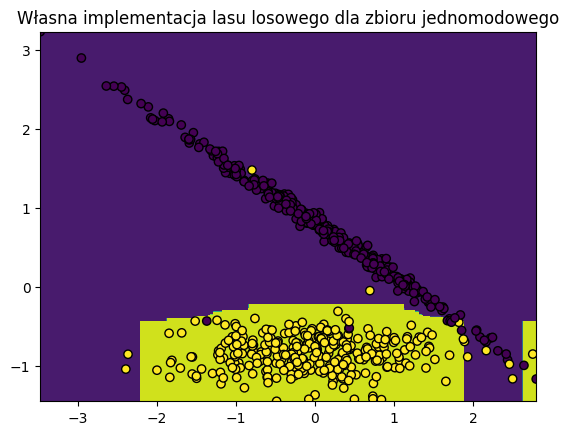

In [ ]:
class RandomForest:
    class RandomTree:
        class Node:
            def __init__(self,value=None,left=None,right=None,feature=None,threshold=None) -> None:
                self.value=value
                self.left=left
                self.right=right
                self.feature=feature
                self.threshold=threshold
                
        def __init__(self,features,max_depth=2) -> None:
            self.features=features
            self.max_depth=max_depth
        def fit(self,X_train,y_train):
            self.tree=self.build_decision_tree(X_train,y_train)
        def build_decision_tree(self,X,y,i=0):
            if i>=self.max_depth or np.unique(y).size == 1:
                return self.Node(value=self._most_common(y))
        
            feature,threshold=self._best_split(X,y)
            left,right=self._split(X[:,feature],threshold)
            left_node=self.build_decision_tree(X[left],y[left],i+1)
            right_node=self.build_decision_tree(X[right],y[right],i+1)
            node=self.Node()
            node.feature=feature
            node.threshold=threshold
            node.left=left_node
            node.right=right_node
            return node
        def _best_split(self,X,y):
            best_gini=float('inf')
            feature=0
            threshold=0
            for i in self.features:
                thresholds=np.unique(X[:,i])
                for t in thresholds:
                    if (gini:=self._gini(X[:,i],y,t))<best_gini:
                        best_gini=gini
                        feature=i
                        threshold=t

            return feature,threshold,
        def _gini(self,X,y,threshold):
            left,right=self._split(X,threshold)
            if len(left) == 0 or len(right) == 0:
                return float('inf')
            lvalues,lcounts=np.unique(y[left],return_counts=True)
            rvalues,rcounts=np.unique(y[right],return_counts=True)
            lsum=np.sum(lcounts)
            rsum=np.sum(rcounts)
            total=lsum+rsum
            lgini=1-np.sum((lcounts/lsum)**2)
            rgini=1-np.sum((rcounts/rsum)**2)
            
            return lgini* lsum/total + rgini * rsum/total
        
        def _most_common(self,elements):
            el,counts=np.unique(elements,return_counts=True)
            return el[np.argmax(counts)]

        def _split(self,X,threshold):
            left=np.argwhere(X<=threshold).flatten()
            right=np.argwhere(X>threshold).flatten()
            return left,right
        def predict(self,X_test):
            result=[]
            for x in X_test:
                node=self.tree
                while node.value==None:
                    if x[node.feature]<node.threshold:
                        node=node.left
                    else:
                        node=node.right
                result.append(node.value)
            return np.array(result)


    def __init__(self,no_trees=100) -> None:
        self.no_trees=no_trees
        self.trees=[]

    def fit(self,X_train,y_train):
       while len(self.trees)!=self.no_trees:
            bootstrapped=np.random.choice(X_train.shape[0],X_train.shape[0],replace=True)
            # X=[]
            # y=[]
            # for element in bootstrapped:
            #     X.append([X_train[element,:]])
            #     y.append([y_train[element]])
            # X=np.array(X)
            # y=np.array(y)
            X=X_train[bootstrapped]
            y=y_train[bootstrapped]
            # print(X.shape)
            no_features=int(np.sqrt(X_train.shape[1]))

            tree=self.RandomTree(features=np.random.choice(X_train.shape[1],no_features,replace=False))
            tree.fit(X,y)
            self.trees.append(tree)
        
    def predict(self,X_test):
        predictions=np.array([tree.predict(X_test) for tree in self.trees])
        return np.array([self._most_common(pred) for pred in predictions.T])
    
    def _most_common(self,elements):
        el,counts=np.unique(elements,return_counts=True)
        return el[np.argmax(counts)]

clf=RandomForest()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
# print(y_pred)
# print(f"TEST={y_test}")
display_classifier_details(y_pred,y_test,"Własna implementacja lasu losowego dla zbioru jednomodowego")
plot_decision_boundary(X_test,y_test,clf,"Własna implementacja lasu losowego dla zbioru jednomodowego")

#%%[markdown]

 # Zadanie na 3 - własna implementacja lasu losowego dla zbioru wielomodowego

	Własna implementacja lasu losowego dla zbioru wielomodowego

          	accuracy: 0.5990566037735849

          	sensitivity: 0.6487804878048781

          	specificity: 0.5754060324825986
        


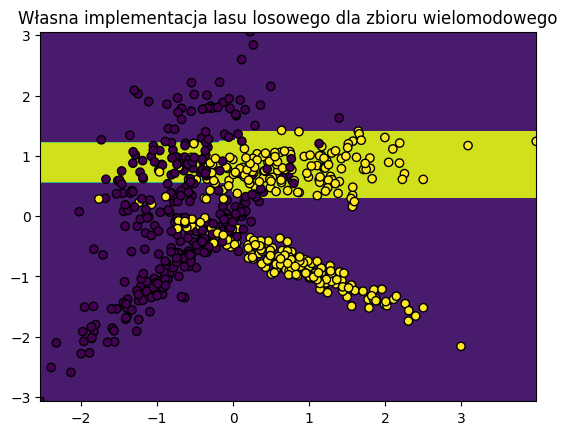

In [ ]:
clf=RandomForest()
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)
display_classifier_details(y2_pred,y2_test,"Własna implementacja lasu losowego dla zbioru wielomodowego")
plot_decision_boundary(X2_test,y2_test,clf,"Własna implementacja lasu losowego dla zbioru wielomodowego")

#%%[markdown]

 # Zadanie na 3 - własna implementacja lasu losowego dla moons

	Własna implementacja lasu losowego dla moons

          	accuracy: 0.9040880503144654

          	sensitivity: 0.8586956521739131

          	specificity: 0.9664179104477612
        


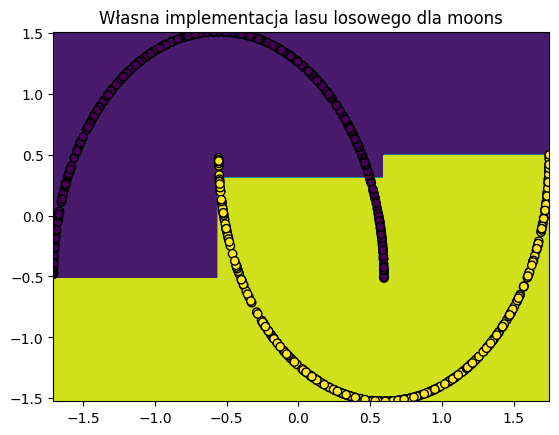

In [ ]:
clf=RandomForest()
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)
display_classifier_details(y_pred_moons,y_test_moons,"Własna implementacja lasu losowego dla moons")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Własna implementacja lasu losowego dla moons")

#%%[markdown]

 # Zadanie na 3 - scikitowa implementacja RandomForestClassifier

	Scikitowa implementacja lasu losowego dla zbioru jednomodowego

          	accuracy: 0.9842767295597484

          	sensitivity: 0.993485342019544

          	specificity: 0.9756838905775076
        
None


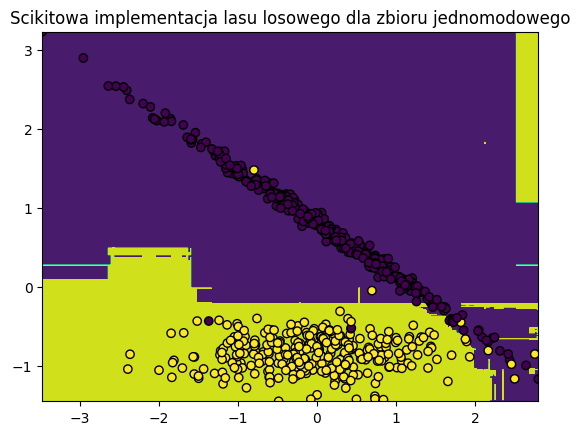

In [ ]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print(display_classifier_details(y_pred,y_test,"Scikitowa implementacja lasu losowego dla zbioru jednomodowego"))
plot_decision_boundary(X_test,y_test,clf,"Scikitowa implementacja lasu losowego dla zbioru jednomodowego")

#%%[markdown]

 # Zadanie na 3 - scikitowa implementacja RandomForestClassifier dla zbioru wielomodowego

	Scikitowa implementacja lasu losowego dla zbioru wielomodowego

          	accuracy: 0.9088050314465409

          	sensitivity: 0.9161290322580645

          	specificity: 0.901840490797546
        
None


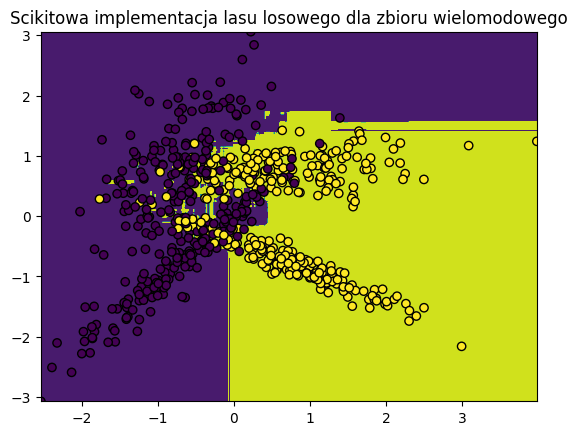

In [ ]:
clf=RandomForestClassifier()
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)

print(display_classifier_details(y2_pred,y2_test,"Scikitowa implementacja lasu losowego dla zbioru wielomodowego"))
plot_decision_boundary(X2_test,y2_test,clf,"Scikitowa implementacja lasu losowego dla zbioru wielomodowego")

#%%[markdown]

 # Zadanie na 3 - scikitowa implementacja RandomForestClassifier dla moons

	Scikitowa implementacja lasu losowego dla moons

          	accuracy: 0.9968553459119497

          	sensitivity: 0.9938837920489296

          	specificity: 1.0
        
None


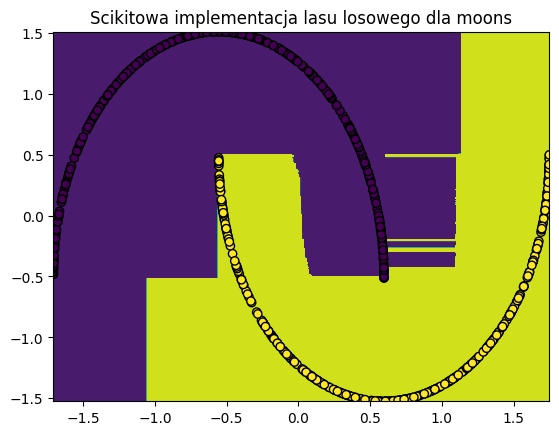

In [ ]:
clf=RandomForestClassifier()
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)

print(display_classifier_details(y_pred_moons,y_test_moons,"Scikitowa implementacja lasu losowego dla moons"))
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Scikitowa implementacja lasu losowego dla moons")

#%%[markdown]

 # Zadanie na 4 - preprocessing danych

In [ ]:
asteroids=pd.read_csv("dataset.csv")
X=[]
t=[]

<ipython-input-12-d7ae7398dca0>:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  asteroids=pd.read_csv("dataset.csv")


In [ ]:
#%%

asteroids

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.400,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.200,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.330,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.000,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.900,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958519,bPLS6013,3246801,(6013 P-L),6013 P-L,NaN,NaN,N,N,17.135,NaN,...,6.969000e+00,7.433000e+00,4.631100e+01,2.738300e+01,1.041200e+00,1.652100e-01,1.309700e+02,7.264900e+02,MBA,0.23839
958520,bPLS6331,3246834,(6331 P-L),6331 P-L,NaN,NaN,N,N,18.500,NaN,...,1.563500e-05,5.598600e-05,2.380400e-04,1.298200e-04,2.418900e-08,3.346100e-09,4.690200e-04,1.578500e-05,MBA,0.53633
958521,bPLS6344,3013075,(6344 P-L),6344 P-L,NaN,NaN,Y,Y,20.400,NaN,...,1.853300e-05,5.691700e-05,8.969200e-05,5.272600e-05,1.650100e-07,1.101600e-08,2.830600e-04,9.127500e-05,APO,0.51556
958522,bT2S2060,3246457,(2060 T-2),2060 T-2,NaN,NaN,N,N,18.071,NaN,...,5.448800e-01,4.391600e+00,1.898800e+01,1.083800e+01,7.171600e-01,1.016700e-01,3.898400e+01,5.035500e+02,MBA,0.25641


In [ ]:
#%%

asteroids=asteroids.drop(["full_name","orbit_id"],axis=1)

#%%[markdown]

 # Zadanie na 4 - preprocessing danych

In [ ]:
asteroids=pd.read_csv("dataset.csv")

<ipython-input-4-a0463fbd3953>:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  asteroids=pd.read_csv("dataset.csv")


In [ ]:
#%%

asteroids=asteroids.drop(["full_name","orbit_id"],axis=1)

In [ ]:
#%%

print(asteroids.dtypes[asteroids.dtypes!=object])

# cols=[c for c in asteroids.columns]
# print(cols)
# X=asteroids[cols]

# 
# t=asteroids["neo"]
# t2=asteroids["pha"]
# scaler=StandardScaler()
# X=scaler.fit_transform(X)

spkid               int64
H                 float64
diameter          float64
albedo            float64
diameter_sigma    float64
epoch             float64
epoch_mjd           int64
epoch_cal         float64
e                 float64
a                 float64
q                 float64
i                 float64
om                float64
w                 float64
ma                float64
ad                float64
n                 float64
tp                float64
tp_cal            float64
per               float64
per_y             float64
moid              float64
moid_ld           float64
sigma_e           float64
sigma_a           float64
sigma_q           float64
sigma_i           float64
sigma_om          float64
sigma_w           float64
sigma_ma          float64
sigma_ad          float64
sigma_n           float64
sigma_tp          float64
sigma_per         float64
rms               float64
dtype: object


In [ ]:
#%%

numerical_cols=asteroids.select_dtypes(include=["int64","float64"]).columns[1:]

X=asteroids[numerical_cols]


t=asteroids["neo"]
t2=asteroids["pha"]
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
#%%

t=np.where(t=="Y",1,0)
t2=np.where(t2=="Y",1,0)

In [ ]:
#%%

print(X[:2500].shape)

(2500, 34)


In [ ]:
#%%

print(np.unique(t[:2500],return_counts=True))

(array([0, 1]), array([2465,   35], dtype=int64))


In [ ]:
#%%

print(np.unique(t,return_counts=True))

(array([0, 1]), array([935629,  22895], dtype=int64))


#%%[markdown]

 # Zadanie na 4 - dobór parametrów

In [ ]:
from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier()
gs=GridSearchCV(clf,{
    'n_estimators':[100,150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}).fit(X[:2500],t[:2500])

#%%[markdown]

 # Zadanie na 4 - najlepsze parametry

In [ ]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

#%%[markdown]

 # Zadanie na 4 - klasyfikator z najlepszymi parametrami

	RandomForestClassifier dla NEO

          	accuracy: 0.9989775947185464

          	sensitivity: 0.9986927155203719

          	specificity: 0.9989949615251791
        


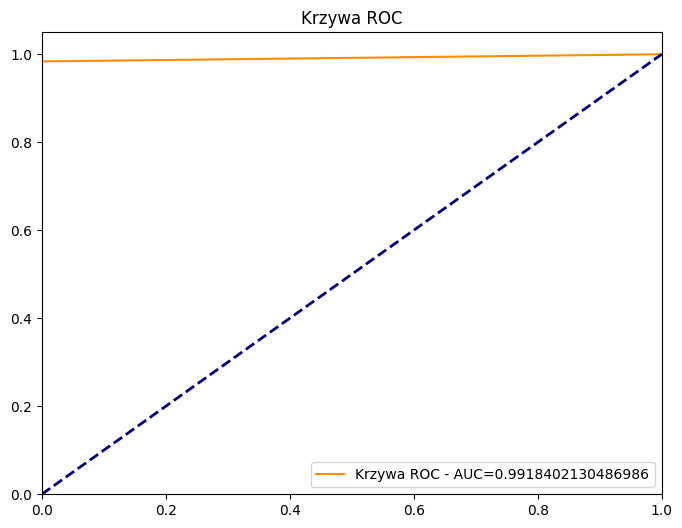

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,t,shuffle=False)
clf=RandomForestClassifier(criterion='gini',max_depth=2,min_samples_leaf=1,min_samples_split=2,n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
display_classifier_details(y_pred,y_test,"RandomForestClassifier dla NEO")
plot_roc_curve(y_test,y_pred)

In [ ]:
#%%

print(np.unique(t2[:2500],return_counts=True))

(array([0, 1]), array([2491,    9], dtype=int64))


In [ ]:
#%%

print(np.unique(t2,return_counts=True))

(array([0, 1]), array([956458,   2066], dtype=int64))


#%%[markdown]

 # Zadanie na 4 - ponowny dobór parametrów

In [ ]:
clf=RandomForestClassifier()
gs=GridSearchCV(clf,{
    'n_estimators':[100,150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2,3],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}).fit(X[:2500],t2[:2500])

#%%[markdown]

 # Zadanie na 4 - najlepsze parametry

In [ ]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

#%%[markdown]

 # Zadanie na 4 - klasyfikator z najlepszymi parametrami

	RandomForestClassifier dla PHA

          	accuracy: 0.996987034231798

          	sensitivity: nan

          	specificity: 0.996987034231798
        


<ipython-input-30-2ae8e1d010aa>:26: RuntimeWarning: invalid value encountered in longlong_scalars
  sensitivity=tp/(tp+fp)


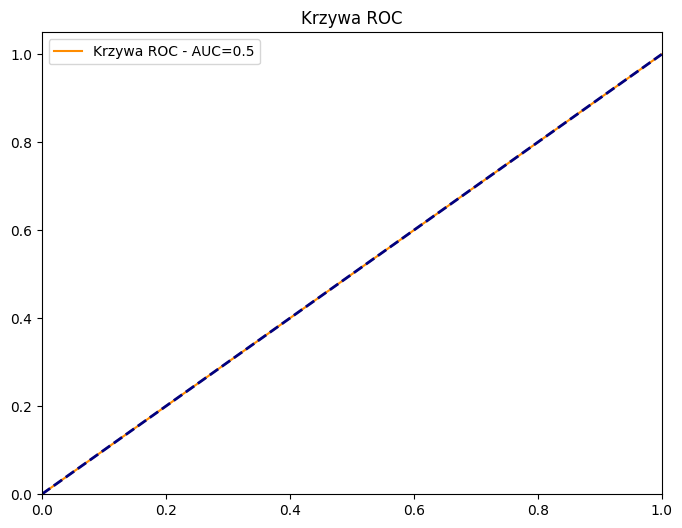

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,t2,shuffle=False)
clf=RandomForestClassifier(criterion='gini',max_depth=2,min_samples_leaf=1,min_samples_split=5,n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
display_classifier_details(y_pred,y_test,"RandomForestClassifier dla PHA")
plot_roc_curve(y_test,y_pred)

#%%[markdown]

 # Zadanie na 5 - badanie wielkości lasu na szybkość inferencji

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X[:2500],t[:2500])

sizes=[100,200,300,500]
for size in sizes:
    print("Scikit")
    for _ in range(5):
        start=time.time()
        
        clf=RandomForestClassifier()
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        
        end=time.time()-start
        print(f"Dla wielkości lasu {size} czas scikitowej implementacji - {end}s\taccuracy: {accuracy_score(y_test,y_pred)}")
    print("Własna implementacja")
    for _ in range(5):
        start=time.time()
    
        clf=RandomForest()
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        
        end=time.time()-start
        print(f"Dla wielkości lasu {size} czas własnej implementacji - {end}s\taccuracy: {accuracy_score(y_test,y_pred)}")

Scikit
Dla wielkości lasu 100 czas scikitowej implementacji - 0.33037233352661133s	accuracy: 1.0
Dla wielkości lasu 100 czas scikitowej implementacji - 0.259401798248291s	accuracy: 1.0
Dla wielkości lasu 100 czas scikitowej implementacji - 0.2713584899902344s	accuracy: 1.0
Dla wielkości lasu 100 czas scikitowej implementacji - 0.2609066963195801s	accuracy: 1.0
Dla wielkości lasu 100 czas scikitowej implementacji - 0.2556624412536621s	accuracy: 1.0
Własna implementacja
Dla wielkości lasu 100 czas własnej implementacji - 130.78494954109192s	accuracy: 0.9984
Dla wielkości lasu 100 czas własnej implementacji - 128.27060508728027s	accuracy: 0.9984
Dla wielkości lasu 100 czas własnej implementacji - 126.17822289466858s	accuracy: 0.9968
Dla wielkości lasu 100 czas własnej implementacji - 133.47398281097412s	accuracy: 0.9984
Dla wielkości lasu 100 czas własnej implementacji - 130.89314985275269s	accuracy: 0.9984
Scikit
Dla wielkości lasu 200 czas scikitowej implementacji - 0.2295398712158203s	

#%%[markdown]

 # Zadanie na 3 - przygotowanie próbek

In [ ]:
n_samples=2544
X,t=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=1,random_state=254479)
X_moons,t_moons=make_moons(n_samples=n_samples,random_state=254479)
X_train,X_test,y_train,y_test=train_test_split(X,t)
X_train_moons,X_test_moons,y_train_moons,y_test_moons=train_test_split(X_moons,t_moons)

#Zbiór wielmodowy
X2,t2=make_classification(n_samples=n_samples,n_features=2,n_informative=2,n_redundant=0,n_clusters_per_class=2,random_state=254479)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,t2)
#Standaryzacja
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

X_train_moons=scaler.fit_transform(X_train_moons)
X_test_moons=scaler.transform(X_test_moons)

X2_train=scaler.fit_transform(X2_train)
X2_test=scaler.transform(X2_test)

#%%[markdown]

 # Zadanie na 3 własna implementacja lasu losowego

	Własna implementacja lasu losowego dla zbioru jednomodowego

          	accuracy: 0.9827044025157232

          	sensitivity: 0.9904153354632588

          	specificity: 0.9752321981424149
        


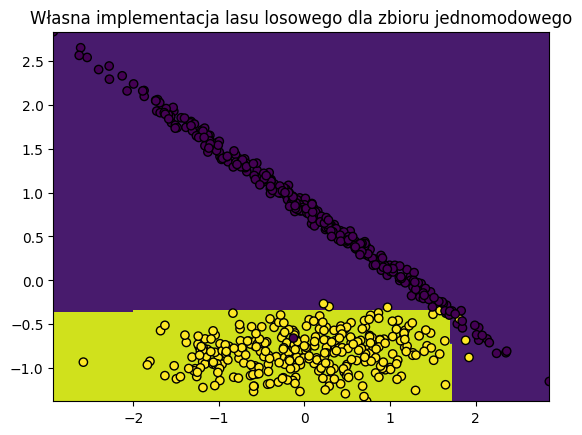

In [ ]:
class RandomForest:
    class RandomTree:
        class Node:
            def __init__(self,value=None,left=None,right=None,feature=None,threshold=None) -> None:
                self.value=value
                self.left=left
                self.right=right
                self.feature=feature
                self.threshold=threshold
                
        def __init__(self,no_features,max_depth=2) -> None:
            self.no_features=no_features
            self.max_depth=max_depth
        def fit(self,X_train,y_train):
            self.tree=self.build_decision_tree(X_train,y_train)
        def build_decision_tree(self,X,y,i=0):
            if i>=self.max_depth or np.unique(y).size == 1:
                return self.Node(value=self._most_common(y))
        
            feature,threshold=self._best_split(X,y)
            left,right=self._split(X[:,feature],threshold)
            left_node=self.build_decision_tree(X[left],y[left],i+1)
            right_node=self.build_decision_tree(X[right],y[right],i+1)
            node=self.Node()
            node.feature=feature
            node.threshold=threshold
            node.left=left_node
            node.right=right_node
            return node
        def _best_split(self,X,y):
            best_gini=float('inf')
            feature=0
            threshold=0
            features=np.random.choice(X.shape[1],self.no_features,replace=False)
            for i in features:
                thresholds=np.unique(X[:,i])
                for t in thresholds:
                    if (gini:=self._gini(X[:,i],y,t))<best_gini:
                        best_gini=gini
                        feature=i
                        threshold=t

            return feature,threshold,
        def _gini(self,X,y,threshold):
            left,right=self._split(X,threshold)
            if len(left) == 0 or len(right) == 0:
                return float('inf')
            lvalues,lcounts=np.unique(y[left],return_counts=True)
            rvalues,rcounts=np.unique(y[right],return_counts=True)
            lsum=np.sum(lcounts)
            rsum=np.sum(rcounts)
            total=lsum+rsum
            lgini=1-np.sum((lcounts/lsum)**2)
            rgini=1-np.sum((rcounts/rsum)**2)
            
            return lgini* lsum/total + rgini * rsum/total
        
        def _most_common(self,elements):
            el,counts=np.unique(elements,return_counts=True)
            return el[np.argmax(counts)]

        def _split(self,X,threshold):
            left=np.argwhere(X<=threshold).flatten()
            right=np.argwhere(X>threshold).flatten()
            return left,right
        def predict(self,X_test):
            result=[]
            for x in X_test:
                node=self.tree
                while node.value==None:
                    if x[node.feature]<node.threshold:
                        node=node.left
                    else:
                        node=node.right
                result.append(node.value)
            return np.array(result)


    def __init__(self,no_trees=100) -> None:
        self.no_trees=no_trees
        self.trees=[]

    def fit(self,X_train,y_train):
       while len(self.trees)!=self.no_trees:
            bootstrapped=np.random.choice(X_train.shape[0],X_train.shape[0],replace=True)
           
            X=X_train[bootstrapped]
            y=y_train[bootstrapped]
            no_features=int(np.sqrt(X_train.shape[1]))

            tree=self.RandomTree(no_features=no_features)
            tree.fit(X,y)
            self.trees.append(tree)
        
    def predict(self,X_test):
        predictions=np.array([tree.predict(X_test) for tree in self.trees])
        return np.array([self._most_common(pred) for pred in predictions.T])
    
    def _most_common(self,elements):
        el,counts=np.unique(elements,return_counts=True)
        return el[np.argmax(counts)]

clf=RandomForest()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

display_classifier_details(y_pred,y_test,"Własna implementacja lasu losowego dla zbioru jednomodowego")
plot_decision_boundary(X_test,y_test,clf,"Własna implementacja lasu losowego dla zbioru jednomodowego")

#%%[markdown]

 # Zadanie na 3 - własna implementacja lasu losowego dla zbioru wielomodowego

	Własna implementacja lasu losowego dla zbioru wielomodowego

          	accuracy: 0.8584905660377359

          	sensitivity: 0.911660777385159

          	specificity: 0.8158640226628895
        


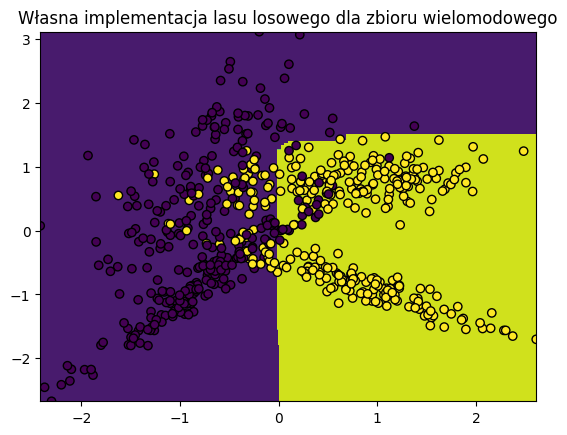

In [ ]:
clf=RandomForest()
clf.fit(X2_train,y2_train)
y2_pred=clf.predict(X2_test)
display_classifier_details(y2_pred,y2_test,"Własna implementacja lasu losowego dla zbioru wielomodowego")
plot_decision_boundary(X2_test,y2_test,clf,"Własna implementacja lasu losowego dla zbioru wielomodowego")

#%%[markdown]

 # Zadanie na 3 - własna implementacja lasu losowego dla moons

	Własna implementacja lasu losowego dla moons

          	accuracy: 0.8977987421383647

          	sensitivity: 0.8415300546448088

          	specificity: 0.9740740740740741
        


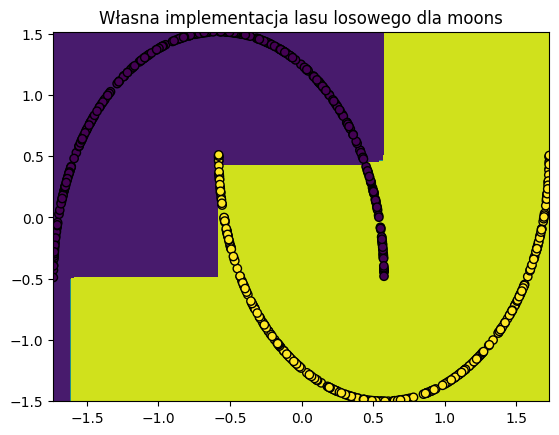

In [ ]:
clf=RandomForest()
clf.fit(X_train_moons,y_train_moons)
y_pred_moons=clf.predict(X_test_moons)
display_classifier_details(y_pred_moons,y_test_moons,"Własna implementacja lasu losowego dla moons")
plot_decision_boundary(X_test_moons,y_test_moons,clf,"Własna implementacja lasu losowego dla moons")

In [ ]:
#%%

numerical_cols=asteroids.select_dtypes(include=["int64","float64"]).columns[1:]

X=asteroids[numerical_cols]


t=asteroids["neo"]
t2=asteroids["pha"]
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [ ]:
#%%

t=np.where(t=="Y",1,0)
t2=np.where(t2=="Y",1,0)

#%%[markdown]

 # Zadanie na 4 - klasyfikator z najlepszymi parametrami

	RandomForestClassifier dla PHA

          	accuracy: 0.99996

          	sensitivity: 0.975609756097561

          	specificity: 0.9999919894902112
        


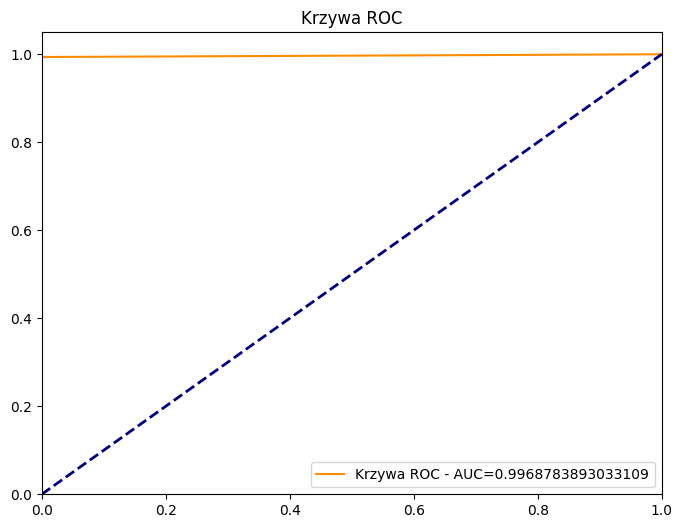

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X[:500000],t2[:500000])
clf=RandomForestClassifier(criterion='gini',max_depth=2,min_samples_leaf=1,min_samples_split=5,n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
display_classifier_details(y_pred,y_test,"RandomForestClassifier dla PHA")
plot_roc_curve(y_test,y_pred)